# ePSman ESgamess class notes & demos: molecule and Gamess job handling class
30/03/21

This class handles Gamess jobs (full pipeline) on a local machine only.

Core functionality is provided by the following libraries:

- [PubChemPy](https://pypi.org/project/PubChemPy/)
   - Interface with [PubChem](https://pubchem.ncbi.nlm.nih.gov).
- [RDKit](https://rdkit.org/docs/index.html)
   - Molecule class/handling routines.
   - Transformations.
   - Figures (2D natively, uses [py3Dmol on the backend](https://pypi.org/project/py3Dmol/) for 3D rendering).
- [pygamess](https://github.com/kzfm/pygamess)
   - Setup Gamess input cards.
   - Run Gamess calculations (local machine only).

This class creates a pipeline with these tools, and implements a few extra helper routines, with the general aim to make this part of the process as painless as possible.

Minimal method for pipeline to ePolyScat jobs:

PubChem download > Fix reference frame (symmetry axis to Z) > Run Gamess > Export/convert.

## Imports

In [1]:
# Import class
from epsman.elecStructure.gamess import ESgamess

## Molecule creation routines

Currently wraps routines from RDkit + PubChemPy for rapid setup from existing sources. Shows 2D structure and coord tabe on execution.

TODO: add support for manual molecule creation. This can be done via a file at the moment, or via RDkit backend (see, for example, [the RDkit docs](https://www.rdkit.org/docs/GettingStartedInPython.html#reading-and-writing-molecules)).

Set name = N2O
Set smiles = None
Set molFile = None
*** File /home/paul/github/epsman/demos/N2O.SDF already exists, pass overwrite=True to overwrite
Set job = None
Set sym = C1
Set atomList = None


RDKit WARNING: [14:38:36] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:38:36] Warning: molecule is tagged as 3D, but all Z coords are zero


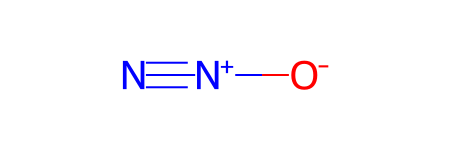

O      8.0      1.3063000000    0.0000000000    0.0000000000 
N      7.0     -0.1096000000    0.0000000000    0.0000000000 
N      7.0     -1.1967000000    0.0000000000    0.0000000000 



In [2]:
# Molecule from PubChem
testDL = ESgamess(searchName = 'N2O')

Set name = None
Set smiles = [N-]=[N+]=O
Set molFile = None
Set job = None
Set sym = C1
Set atomList = None


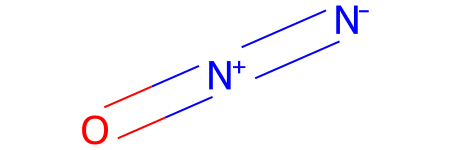

N      7.0      1.1203318954    0.1103129733    0.0000000000 
N      7.0     -0.0066842804   -0.3821096381    0.0000000000 
O      8.0     -1.1136476150   -0.8657704075    0.0000000000 



In [3]:
# Molecule from SMILES
testSmiles = ESgamess(smiles = '[N-]=[N+]=O')

Set name = None
Set smiles = None
Set molFile = N2O.SDF
Set job = None
Set sym = C1
Set atomList = None


RDKit WARNING: [14:38:36] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:38:36] Warning: molecule is tagged as 3D, but all Z coords are zero


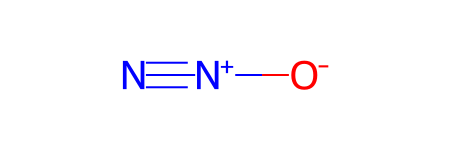

O      8.0      1.3063000000    0.0000000000    0.0000000000 
N      7.0     -0.1096000000    0.0000000000    0.0000000000 
N      7.0     -1.1967000000    0.0000000000    0.0000000000 



In [4]:
# From file, e.g. SDF file downloaded from PubChem above.
# This uses RDkit Chem.MolFromMolFile() on the backend, 
# For details of files supported see https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html

testFile = ESgamess(molFile = 'N2O.SDF')


### Additional info

If `Pandas` is available, a fancy print is available with `printTable()`.

In [5]:
testDL.printTable()

,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,1.3063,0.0,0.0
1,1,N,7,-0.1096,0.0,0.0
2,2,N,7,-1.1967,0.0,0.0


If `py3Dmol` is available, interactive 3D plots are available in notebooks with `plot3D()`.

In [6]:
testDL.plot3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The molecule is stored as an RDkit object, `self.mol`, and [RDkit methods are also available](https://www.rdkit.org/docs/GettingStartedInPython.html).

In [7]:
type(testDL.mol)

rdkit.Chem.rdchem.Mol

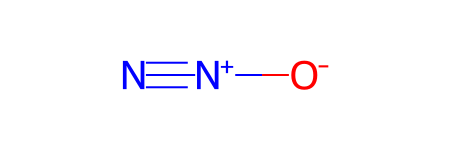

In [8]:
# Calling the object will render it
testDL.mol

In [9]:
# RDkit method example
testDL.mol.GetNumAtoms()

3

## pyGamess wrapper

### Setup Gamess job

In [10]:
# Init the pyGamess job.
# This minimally needs a gamess_path set, which defaults to '/opt/gamess'
testDL.initGamess() # Using defaults

*** Init pyGamess job.
Default Gamess input card set (use self.params to modify options dictionary, self.setGamess() to test):

 $contrl scftyp=rhf runtyp=energy $end
 $basis gbasis=sto ngauss=3 $end
 $system mwords=30 $end
 $DATA
None
C1
O      8.0      1.3063000000    0.0000000000    0.0000000000 
N      7.0     -0.1096000000    0.0000000000    0.0000000000 
N      7.0     -1.1967000000    0.0000000000    0.0000000000 
 $END



This creates a `pyGamess` object, accessible at `self.g`.

In [11]:
print(type(testDL.g))
print(testDL.g.gamess_path)

<class 'epsman.elecStructure.gamess.gamessInput'>
/opt/gamess


All Gamess job parameters are stored in a dictionary, at `self.params` (also `self.g.options`), and can be set there directly. See the [pyGamess docs for more info](https://github.com/kzfm/pygamess).

`pyGamess` doesn't support symmetry or job annotation (uses 'C1' only), this can be added via a class wrapper here, and can be set via `self.setGamess`.

**Note that is symmetry is set to anything other than 'C1', coordinate transforms may be required - [see notes below.](#Symmetry-&-frame-transformations)**

In [12]:
testDL.params

{'contrl': {'scftyp': 'rhf', 'runtyp': 'energy'},
 'basis': {'gbasis': 'sto', 'ngauss': '3'},
 'statpt': {'opttol': '0.0001', 'nstep': '20'},
 'system': {'mwords': '30'},
 'cis': {'nstate': '1'},
 'extra': {'job': None, 'sym': 'C1', 'atomList': None}}

This adds an `extras` item to the params dictionary.

In [13]:
testDL.params

{'contrl': {'scftyp': 'rhf', 'runtyp': 'energy'},
 'basis': {'gbasis': 'sto', 'ngauss': '3'},
 'statpt': {'opttol': '0.0001', 'nstep': '20'},
 'system': {'mwords': '30'},
 'cis': {'nstate': '1'},
 'extra': {'job': None, 'sym': 'C1', 'atomList': None}}

Where `atomList` can additionally be set to sub-select on which atoms are listed on the input card for symmetrized jobs (TODO: make this better/automated!).

The current Gamess input card can always be checked via `self.printGamessInput()`

In [14]:
testDL.printGamessInput()

*** Gamess input card:
 $contrl scftyp=rhf runtyp=energy $end
 $basis gbasis=sto ngauss=3 $end
 $system mwords=30 $end
 $DATA
None
C1
O      8.0      1.3063000000    0.0000000000    0.0000000000 
N      7.0     -0.1096000000    0.0000000000    0.0000000000 
N      7.0     -1.1967000000    0.0000000000    0.0000000000 
 $END



### Run Gamess

If a valid `gamess_path` is set, then this is simple, and the basic results are returned to `self.mol`.

In [15]:
# Run as per input card
testDL.runGamess()

INFO:pygamess.gamess:Executeing py_rungms with command /opt/gamess/ddikick.x /opt/gamess/gamess.00.x watddq -ddi 1 1 jake -scr /tmp/tmpv0_0f1_d > /tmp/tmpv0_0f1_d/watddq.out


*** Energy run completed
E = -181.1830797993


In [16]:
# Run optimization, in this case the updated coord table is also shown.
testDL.runGamess(runType = 'optimize')

INFO:pygamess.gamess:Executeing py_rungms with command /opt/gamess/ddikick.x /opt/gamess/gamess.00.x uopeyh -ddi 1 1 jake -scr /tmp/tmpv0_0f1_d > /tmp/tmpv0_0f1_d/uopeyh.out


*** Optimized self.mol
E = -181.1830797993


,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,1.3063,0.0,0.0
1,1,N,7,-0.1096,0.0,0.0
2,2,N,7,-1.1967,0.0,0.0


However, in the default case the tmp files are not kept. To keep the full Gamess output, supply a filename (full path).

In [17]:
# Check for tmp file
print(testDL.g.gamout)

!cat {testDL.g.gamout}

/tmp/tmpv0_0f1_d/uopeyh.out
cat: /tmp/tmpv0_0f1_d/uopeyh.out: No such file or directory


In [18]:
# runGamess wrapper will take a path and move the output file.
testDL.runGamess(fileOut = '/tmp/test.out')

INFO:pygamess.gamess:Executeing py_rungms with command /opt/gamess/ddikick.x /opt/gamess/gamess.00.x ytegoc -ddi 1 1 jake -scr /tmp/tmpv0_0f1_d > /tmp/tmpv0_0f1_d/ytegoc.out


*** Energy run completed
E = -181.1830797993
*** Gamess output file moved to /tmp/test.out


In [19]:
# In this case the complete output file can also be printed
testDL.printGamess()


 Distributed Data Interface kickoff program.
 Initiating 1 compute processes on 1 nodes to run the following command:
 /opt/gamess/gamess.00.x ytegoc 

          ******************************************************
          *         GAMESS VERSION = 30 SEP 2018 (R3)         *
          *             FROM IOWA STATE UNIVERSITY             *
          * M.W.SCHMIDT, K.K.BALDRIDGE, J.A.BOATZ, S.T.ELBERT, *
          *   M.S.GORDON, J.H.JENSEN, S.KOSEKI, N.MATSUNAGA,   *
          *          K.A.NGUYEN, S.J.SU, T.L.WINDUS,           *
          *       TOGETHER WITH M.DUPUIS, J.A.MONTGOMERY       *
          *         J.COMPUT.CHEM.  14, 1347-1363(1993)        *
          **************** 64 BIT LINUX VERSION ****************

  SINCE 1993, STUDENTS AND POSTDOCS WORKING AT IOWA STATE UNIVERSITY
  AND ALSO IN THEIR VARIOUS JOBS AFTER LEAVING ISU HAVE MADE IMPORTANT
  CONTRIBUTIONS TO THE CODE:
     IVANA ADAMOVIC, CHRISTINE AIKENS, YURI ALEXEEV, POOJA ARORA,
     ANDREY ASADCHEV, ROB B

## Symmetry & frame transformations

To use symmetry in the Gamess calculations, the system must be oriented such that the Z-axis is the highest symmetry axis. In tests both PubChem and RDkit seem to use the X-axis as the symmetry axis, so the frame needs to be rotated in general.

From the [Gamess manual](https://www.msg.chem.iastate.edu/gamess/GAMESS_Manual/docs-input.txt):

```
    The 'master frame' is just a standard orientation for
the molecule.  By default, the 'master frame' assumes that
    1.   z is the principal rotation axis (if any),
    2.   x is a perpendicular two-fold axis (if any),
    3.  xz is the sigma-v plane (if any), and
    4.  xy is the sigma-h plane (if any).
Use the lowest number rule that applies to your molecule.

        Some examples of these rules:
Ammonia (C3v): the unique H lies in the XZ plane (R1,R3).
Ethane (D3d): the unique H lies in the YZ plane (R1,R2).
Methane (Td): the H lies in the XYZ direction (R2).  Since
         there is more than one 3-fold, R1 does not apply.
HP=O (Cs): the mirror plane is the XY plane (R4).

In general, it is a poor idea to try to reorient the
molecule.  Certain sections of the program, such as the
orbital symmetry assignment, do not know how to deal with
cases where the 'master frame' has been changed.

Linear molecules (C4v or D4h) must lie along the z axis,
so do not try to reorient linear molecules.
```

This is set with `self.rotateFrame()`, which can set arbitrary rotations, but defaults to X > Z axis transformation. This uses the RDkit canoicalise and transformation functions, with rotation matrices, as per [Github user iwatobipen's example notebook](https://nbviewer.jupyter.org/github/iwatobipen/playground/blob/master/rotation_mol.ipynb). (Thanks to [iwatobipen](https://github.com/iwatobipen) and the [RDkit list](https://sourceforge.net/p/rdkit/mailman/message/36598250/).)

In [20]:
testDL.rotateFrame()

*** Set frame rotations, new coord table:


,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,7.998781e-17,0.0,-1.3063
1,1,N,7,-6.711064e-18,0.0,0.1096
2,2,N,7,-7.327674e-17,0.0,1.1967


Symmetry groups supported (from the [Gamess manual](https://www.msg.chem.iastate.edu/gamess/GAMESS_Manual/docs-input.txt)):

```
GROUP is the Schoenflies symbol of the symmetry group,
you may choose from
    C1, Cs, Ci, Cn, S2n, Cnh, Cnv, Dn, Dnh, Dnd,
    T, Th, Td, O, Oh.

NAXIS is the order of the highest rotation axis, and
must be given when the name of the group contains an N.
For example, "Cnv 2" is C2v.  "S2n 3" means S6.  Use of
NAXIS up to 8 is supported in each axial groups.

For linear molecules, choose either Cnv or Dnh, and enter
NAXIS as 4.  Enter atoms as Dnh with NAXIS=2.  If the
electronic state of either is degenerate, check the note
about the effect of symmetry in the electronic state
in the SCF section of REFS.DOC.
```

In [21]:
# Set Gamess input with symmetry
testDL.setGamess(note='N2O sym testing', sym='CNV 8')

*** Gamess input card:
 $contrl scftyp=rhf runtyp=energy $end
 $basis gbasis=sto ngauss=3 $end
 $system mwords=30 $end
 $DATA
N2O sym testing
CNV 8

O      8.0      0.0000000000    0.0000000000   -1.3063000000 
N      7.0     -0.0000000000    0.0000000000    0.1096000000 
N      7.0     -0.0000000000    0.0000000000    1.1967000000 
 $END



Finally, it is worth noting that symmetrized jobs require only the unique atoms given on the input card. This is currently accomplished here rather crudely, via a list of atom indices (rows) to the input builder.

For example...

In [22]:
testDL.setGamess(note='N2O sym testing', sym='CNV 8', atomList = [0,2])

*** Gamess input card:
 $contrl scftyp=rhf runtyp=energy $end
 $basis gbasis=sto ngauss=3 $end
 $system mwords=30 $end
 $DATA
N2O sym testing
CNV 8

O      8.0      0.0000000000    0.0000000000   -1.3063000000 
N      7.0     -0.0000000000    0.0000000000    1.1967000000 
 $END



## Additional Gamess parameters

For the full set of [Gamess input options (inc. basis sets), see the manual](https://www.msg.chem.iastate.edu/gamess/GAMESS_Manual/docs-input.txt).

As per the above input cards, `pyGamess` writes only the minimal set of `$contrl`, `$basis` and `$system` inputs, using the supplied parameters dictionary.

TODO: wrap the input writer for arb sections from the params dictionary.

In [23]:
# Basis sets can additionally be set using pyGamess 
testDL.g.basis_set("6-31G**")

{'gbasis': 'N31', 'ngauss': '6', 'ndfunc': '1', 'npfunc': '1'}

In [24]:
# This only has limited support...
testDL.g.basis_set("ACCD")

ERROR:pygamess.gamess:basis type not found


{'gbasis': 'N31', 'ngauss': '6', 'ndfunc': '1', 'npfunc': '1'}

In [25]:
# ... applying settings manually will always work however
testDL.params['basis'] = {'gbasis':'ACCD'}
testDL.params['contrl']['ISPHER']='1'  # For ACCD need this too! 
testDL.params

{'contrl': {'scftyp': 'rhf', 'runtyp': 'energy', 'ISPHER': '1'},
 'basis': {'gbasis': 'ACCD'},
 'statpt': {'opttol': '0.0001', 'nstep': '20'},
 'system': {'mwords': '30'},
 'cis': {'nstate': '1'},
 'extra': {'job': 'N2O sym testing', 'sym': 'CNV 8', 'atomList': [0, 2]}}

In [26]:
testDL.printGamessInput()

*** Gamess input card:
 $contrl scftyp=rhf runtyp=energy ISPHER=1 $end
 $basis gbasis=ACCD $end
 $system mwords=30 $end
 $DATA
N2O sym testing
CNV 8

O      8.0      0.0000000000    0.0000000000   -1.3063000000 
N      7.0     -0.0000000000    0.0000000000    1.1967000000 
 $END



## Additional transformations - bond lengths & angles

These can be addressed using the [RDkit functionality](https://rdkit.org/docs/source/rdkit.Chem.rdMolTransforms.html).

There is also a wrapper for bond lengths at the moment, `self.setBondLength`, which takes a dictionary of bonds to set, in the format `{'Name':{'a1':0,'a2':1,'l':5}}` where 'a1' and 'a2' give the atom indices for atoms defining the bond. This wraps RDkit's [rdkit.Chem.rdMolTransforms.SetBondLength](https://rdkit.org/docs/source/rdkit.Chem.rdMolTransforms.html#rdkit.Chem.rdMolTransforms.SetBondLength).

TODO: clean up input, wrap angle setting functions(?).

Here's a basic bond-length example

In [27]:
testDL.printTable()

,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,7.998781e-17,0.0,-1.3063
1,1,N,7,-6.711064e-18,0.0,0.1096
2,2,N,7,-7.327674e-17,0.0,1.1967


In [28]:
bonds = {'NO':{'a1':0, 'a2':1, 'l':5}, 'NN':{'a1':1, 'a2':2, 'l':5}}
# testDL.setBondLength(bonds = {'NO':{'a0':0, 'a1':1, 'l':5}})
testDL.setBondLength(bonds)

*** Set bonds, new coord table:


,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,7.998781e-17,0.0,-1.3063
1,1,N,7,-2.261739e-16,0.0,3.6937
2,2,N,7,-5.323356e-16,0.0,8.6937


Note that the RDkit routines move all atoms as appropriate for the new settings.

## Minimal job pipeline to generate electronic structure & input files for ePolyScat

Possibly not advisable, since errors may go unnoticed, but the whole default pipeline can be executed with `self.buildES()`, which aims to string together the default cases above and produce a Gamess output file that can be used as input for ePolyScat. 

This can be run directly at class creation by passing `buildES=True`. To keep the Gamess output file, pass fileOut.

Set name = N2O
Set smiles = None
Set molFile = None
*** File /home/paul/github/epsman/demos/N2O.SDF already exists, pass overwrite=True to overwrite
Set job = None
Set sym = C1
Set atomList = None


RDKit WARNING: [14:39:01] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [14:39:01] Warning: molecule is tagged as 3D, but all Z coords are zero


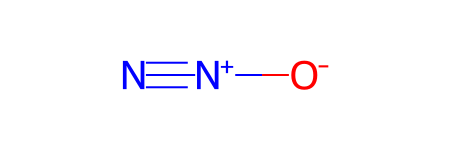

O      8.0      1.3063000000    0.0000000000    0.0000000000 
N      7.0     -0.1096000000    0.0000000000    0.0000000000 
N      7.0     -1.1967000000    0.0000000000    0.0000000000 

*** Running default Gamess job.
*** Set frame rotations, new coord table:


,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,7.998781e-17,0.0,-1.3063
1,1,N,7,-6.711064e-18,0.0,0.1096
2,2,N,7,-7.327674e-17,0.0,1.1967


INFO:pygamess.gamess:Executeing py_rungms with command /opt/gamess/ddikick.x /opt/gamess/gamess.00.x jfqorx -ddi 1 1 jake -scr /tmp/tmpq79qm8ni > /tmp/tmpq79qm8ni/jfqorx.out


*** Init pyGamess job.
Default Gamess input card set (use self.params to modify options dictionary, self.setGamess() to test):

 $contrl scftyp=rhf runtyp=energy $end
 $basis gbasis=sto ngauss=3 $end
 $system mwords=30 $end
 $DATA
None
C1
O      8.0      0.0000000000    0.0000000000   -1.3063000000 
N      7.0     -0.0000000000    0.0000000000    0.1096000000 
N      7.0     -0.0000000000    0.0000000000    1.1967000000 
 $END

*** Energy run completed
E = -181.1830797993
*** Gamess output file moved to /tmp/autobuild.out


,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,7.998781e-17,0.0,-1.3063
1,1,N,7,-6.711064e-18,0.0,0.1096
2,2,N,7,-7.327674e-17,0.0,1.1967


INFO:pygamess.gamess:deleting tempdir /tmp/tmp35n9bn2b


In [30]:
# Set via build=True - to do
testBuild = ESgamess(searchName = 'N2O', fileOut = '/tmp/autobuild.out', buildES = True)

In [32]:
# Running the function also works
testDL.buildES(fileOut = '/tmp/autobuild.out')

*** Running default Gamess job.
*** Set frame rotations, new coord table:


,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,-3.061617e-16,-1.232595e-32,5.0
1,1,N,7,0.000000e+00,0.000000e+00,0.0
2,2,N,7,3.061617e-16,0.000000e+00,-5.0


INFO:pygamess.gamess:Executeing py_rungms with command /opt/gamess/ddikick.x /opt/gamess/gamess.00.x eqbqbl -ddi 1 1 jake -scr /tmp/tmpz6c50ibb > /tmp/tmpz6c50ibb/eqbqbl.out


*** Init pyGamess job.
Default Gamess input card set (use self.params to modify options dictionary, self.setGamess() to test):

 $contrl scftyp=rhf runtyp=energy $end
 $basis gbasis=sto ngauss=3 $end
 $system mwords=30 $end
 $DATA
None
C1
O      8.0     -0.0000000000   -0.0000000000    5.0000000000 
N      7.0      0.0000000000    0.0000000000    0.0000000000 
N      7.0      0.0000000000    0.0000000000   -5.0000000000 
 $END

*** Energy run completed
E = -161.7465089353
*** Gamess output file moved to /tmp/autobuild.out


,Ind,Species,Atomic Num.,x,y,z
0,0,O,8,-3.061617e-16,-1.232595e-32,5.0
1,1,N,7,0.000000e+00,0.000000e+00,0.0
2,2,N,7,3.061617e-16,0.000000e+00,-5.0
